In [2]:
import tensorflow as tf
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm import tqdm
mpl.rcParams['figure.dpi'] = 250

k562_bpnet = tf.keras.models.load_model('/kaggle/input/chrombpnet-data/k562_chrombpnet_wo_bias.h5', compile=False)
gm12878_bpnet = tf.keras.models.load_model('/kaggle/input/chrombpnet-data/gm12878_chrombpnet_wo_bias.h5', compile=False)
hepg2_bpnet = tf.keras.models.load_model('/kaggle/input/chrombpnet-data/hepg2_chrombpnet_wo_bias.h5', compile=False)
h1esc_bpnet = tf.keras.models.load_model('/kaggle/input/chrombpnet-data/h1esc_chrombpnet_wo_bias.h5', compile=False)
df = pd.read_csv('/kaggle/input/chrombpnet-data/processed_data_removed.txt')

2023-02-17 00:00:17.797577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 00:00:17.898096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 00:00:17.898895: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 00:00:17.900721: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [3]:
import pandas as pd
df = pd.read_csv('/kaggle/input/chrombpnet-data/processed_data_removed.txt')
df.head()

,Unnamed: 0,dhs_id,chrom,chromStart,chromEnd,DHS_width,summit,numsamples,total_signal,component,proportion,GM12878_ENCLB441ZZZ,hESCT0_ENCLB449ZZZ,K562_ENCLB843GMH,HepG2_ENCLB029COU,TAG,addtional_rep_with_this_peak,other_samples_with_this_peak_not_considering_reps,data_label,Full_Sequence
0,0,chr14_92895527_92895734_92895650,chr14,92894573,92896687,207,92895650,2,2.41656,1,0.508887,1,0,0,0,GM12878_ENCLB441ZZZ,1,0,training,CTTGGTTGCCAGTGGAAATGGCAGCAGGAAGAACACACTGCCTCTT...
1,1,chr16_84088800_84089180_84088970,chr16,84087933,84090047,380,84088970,2,5.17234,1,0.508887,1,0,0,0,GM12878_ENCLB441ZZZ,1,0,training,TAACAAACCTGCAGCTGGAAACTGGATCCCTTTTAAACCAGCCGCC...
2,2,chr17_63517040_63517143_63517070,chr17,63516034,63518148,103,63517070,2,1.41943,1,0.508887,1,0,0,0,GM12878_ENCLB441ZZZ,1,0,training,ACCCTAGTGGAACTAGACACCCACGCACCCATTGCCTGATTGGGGA...
3,3,chr5_95617159_95617377_95617270,chr5,95616211,95618325,218,95617270,2,4.34546,1,0.508887,1,0,0,0,GM12878_ENCLB441ZZZ,1,0,training,GCATCCAGATTCAACTGCTAATCAGAAAATCTGGGTTTTGGCCCCT...
4,4,chr5_151721128_151721540_151721390,chr5,151720277,151722391,412,151721390,2,8.54241,1,0.508887,1,0,0,0,GM12878_ENCLB441ZZZ,1,0,training,ACTGGTGTGAGATGATATCTAATAGTGGTTTTGATTTGCATTTCTC...


# Extending Sequences to length 2114

In [4]:
!pip install ucsc_genomes_downloader
from ucsc_genomes_downloader import Genome
hg38 = Genome(assembly="hg38")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.4/293.4 kB 1.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ucsc_genomes_downloader: filename=ucsc_genomes_downloader-1.1.26-py3-none-any.whl size=14974 sha256=de7fc140ea3e2d32ac51814eb097cb8b186fe7b529597dbbc3d8904e84181ead
  Stored in directory: /root/.cache/pip/wheels/37/b6/77/31467f98789328aab176cbde40dcf81386855ad65bf235a853
  Created wheel for compress_json: filename=compress_json-1.0.8-py3-none-any.whl size=4730 sha256=f3f13fb4e4eb9721d97f622a995316b85791dd71c6087553ab7b086faa4d2f32
  Stored in directory: /root/.cache/pip/wheels/93/9f/a4/13810037c24ad31f1f42fe769d4cbe6665d8d081c322b3483b
  Created wheel for

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

In [6]:
df = df.rename(columns={'chr': 'chrom', 'start': 'chromStart', 'end': 'chromEnd'})

a = []
b = []
for ind, row in df.iterrows():
    flank_len = (2114 - (row['chromEnd'] - row['chromStart']))//2
    a1 = row['chromEnd'] + flank_len
    b1 = row['chromStart'] - flank_len
    if a1 - b1 == 2113:
        b1 -= 1
    elif a1 - b1 == 2115:
        b1 += 1
    b.append(b1)
    a.append(a1)
df['chromEnd'] = a
df['chromStart'] = b

sequences = hg38.bed_to_sequence(df)
for i in range(len(sequences)):
    sequences[i] = sequences[i].upper()

df['Full_Sequence'] = sequences
df.to_csv('processed_data.txt', sep=',', header=True)
indices = []
for i, j in enumerate(sequences):
    if len(j) != 2114: indices.append(i)
df_removed = df.drop(indices)
df.to_csv('processed_data_removed.txt', sep=',', header=True, index=False)

# Shuffling DNA Sequences (getting negative sequences)

In [7]:
full_sequences = df['Full_Sequence']
shuffled_sequences = []
for i in range(len(full_sequences)):
    if type(full_sequences[i]) == str:
        shuffled_sequences.append(''.join(random.sample(full_sequences[i], len(full_sequences[i]))))
    else:
        shuffled_sequences.append(full_sequences[i])

df['Shuffled_Sequence'] = shuffled_sequences

# Running chrombpnet

In [9]:
def preprocess_sequence(seq):
    letter2ind = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    sequence = []
    for i in range(2114): sequence.append(letter2ind[seq[i]])
    sequence = np.array(sequence)
    b = np.zeros((sequence.size, sequence.max() + 1))
    b[np.arange(sequence.size), sequence] = 1
    return b[None, :]

def plot_chrom_accessibility(k562_output, gm12878_output, hepg2_output, h1esc_output, window=200):
    one_kb_window = int((window//2)/2114*1000)
    plt.plot(list(range(94)), k562_output[0][0, 500-one_kb_window:500+one_kb_window], "r-")
    plt.plot(list(range(94)), gm12878_output[0][0, 500-one_kb_window:500+one_kb_window], "g-")
    plt.plot(list(range(94)), hepg2_output[0][0, 500-one_kb_window:500+one_kb_window], "b-")
    plt.plot(list(range(94)), h1esc_output[0][0, 500-one_kb_window:500+one_kb_window], "y-")
    plt.title('Chromatin Accessibility')
    
def quantile_normalization(A):
        AA = np.zeros_like(A)
        I = np.argsort(A, axis=0)
        AA[I, np.arange(A.shape[1])] = np.mean(A[I, np.arange(A.shape[1])], axis=1)[:, np.newaxis]
        return AA

In [11]:
heatmap = []
labels = []

for row_num, row in tqdm(df.iterrows(), total=df.shape[0]):
    curr_seq = row['Full_Sequence']
    if type(curr_seq) != str or 'N' in curr_seq: continue
    curr_seq = preprocess_sequence(curr_seq)
    cell_type = row['TAG'][:row['TAG'].index('_')]
    for a, seq in enumerate([curr_seq, preprocess_sequence(row['Shuffled_Sequence'])]):
        gm12878_output = np.mean(gm12878_bpnet(seq)[0][0, 453:547])
        h1esc_output = np.mean(h1esc_bpnet(seq)[0][0, 453:547])
        k562_output = np.mean(k562_bpnet(seq)[0][0, 453:547])
        hepg2_output = np.mean(hepg2_bpnet(seq)[0][0, 453:547])
        heatmap.append([gm12878_output, h1esc_output, k562_output, hepg2_output])
        if a == 0: labels.append(cell_type + str(row_num))
        else: labels.append('Random' + str(row_num))

heatmap = np.array(heatmap)
heatmap = quantile_normalization(heatmap)

 25%|██▍       | 11854/47872 [29:59<1:28:58,  6.75it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 38%|███▊      | 18050/47872 [45:49<1:12:43,  6.83it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 47872/47872 [2:01:49<00:00,  6.55it/s]  


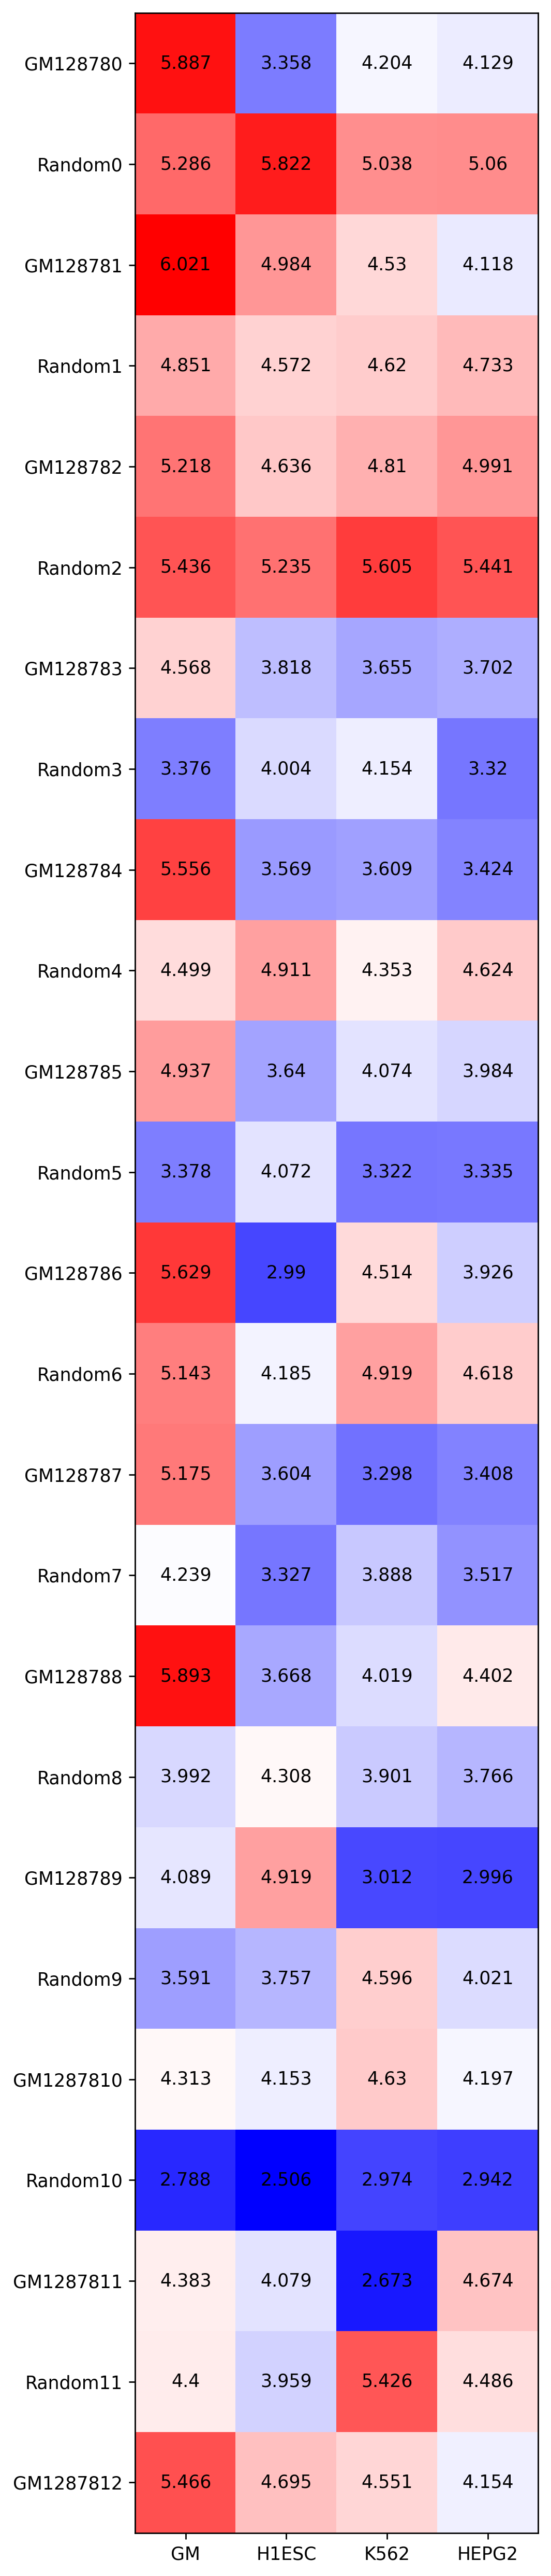

In [24]:
cell_type = ["GM", "H1ESC", "K562", "HEPG2"]
fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(20)
im = ax.imshow(heatmap[:25, :], cmap=mpl.colormaps['bwr'])
ax.set_xticks(np.arange(len(cell_type)), labels=cell_type)
# ax.set_yticks(np.arange(len(labels)), labels=labels)
ax.set_yticks(np.arange(25), labels=labels[:25])


for i in range(25):
    for j in range(len(cell_type)):
        text = ax.text(j, i, round(heatmap[i, j], 3), ha="center", va="center", color="black")
fig.tight_layout()
plt.show()